# 10장. 시퀀스를 예측하는 머신러닝 모델 만들기

1. 윈도 데이터셋 만들기

tf.data 라이브러리: 데이터 조작에 유용한 도구들이 존재.

1) 
----
1. tf.data.Dataset.range() 함수를 이용하여 0~9까지의 값을 담는 데이터셋 생성

2. dataset.window()함수를 이용하여 데이터셋을 5개 항목으로 구성된 인도로 나누고,    
shift=항목개수를 설정.   
drop_remainder=True로 설정하여 데이터셋의 마지막 부분에서 윈도 크기보다 작은 개수가 남으면 해당 윈도를 drop(버리도록))   
==> dataset

3. 정의된 윈도를 사용하여 데이터셋 분할을 수행: dataset.flat_map() 내에 5개 항목을 가진 배치를 생성: window.batch=배치항목 개수

4. n개의 값을 특성으로 사용하고, 이어지는 하나의 값을 레이블로 사용하는 훈련 데이터 생성   
  dataset.map() 내에 lambda함수를 적용하여 각 윈도를 마지막 이전의 값과 마지막 값으로 분리

참고)   
lambda함수: 함수명=lambda 파라미터: 함수식      
예) def adder1(a, b):    
        return a+b   
=> adder2 = lambda a,b: a+b   
print(adder1(1,2))   
print(adder2(1,2))   
   
lambda 함수 응용 -> 고차함수   
고차함수: 함수를 파라미터로 사용하거나 반환값으로 사용하는 함수   
1) map(함수, 리스트): 리스트 항목마다 함수를 적용   
  num_list = [1,2,3]   
  result = map(lambda x : x*x, num_list)   

2) reduce(함수 ,자료형): 순서가 있는 자료형(문자열, 리스트, 튜플)에 사용. 결과값을 누적해서 연산.   
  from functools import reduce   
  num_list = [1,2,3,4]   
  result = reduce(lambda a,b : a+b, num_list)   
   
  result = reduce(lambda a,b: b+a, "abcde")   
   
3) filter(함수, 리스트): 걸러주는 기능. 원하는 조건에 맞는 항목만 추출 가능.   
  num_list = [1,2,3,4,5,6,7,8,9,10]   
  result = filter(lambda x : x%2 != 0, num_list)   

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True) 
dataset = dataset.flat_map(lambda window: window.batch(5)) # 분할
for window in dataset:
    print(window.numpy())

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [3]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5)) # 분할
dataset = dataset.map(lambda window: (window[:-1], window[-1:])) # 뒤에 하나는 레이블로 뽑을 거에요
for x,y in dataset:
    print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [4]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5)) # 분할
dataset = dataset.map(lambda window: (window[:-1], window[-1:])) # 뒤에 하나는 레이블로 뽑을 거에요
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x,y in dataset:
    print("x = ", x.numpy())
    print("y = ", y.numpy())

x =  [[0 1 2 3]
 [2 3 4 5]]
y =  [[4]
 [6]]
x =  [[1 2 3 4]
 [3 4 5 6]]
y =  [[5]
 [7]]
x =  [[5 6 7 8]
 [4 5 6 7]]
y =  [[9]
 [8]]


시퀀스를 예측하는 머신러닝 모델 만들기

시계열 데이터를 구성할 때,   
=> 윈도(Window) 데이터셋을 만든다

시간 t의 값 = 시간 t 이전의 값으로 예측.   
예) 이전 30개의 값으로 타임스텝 1,200의 값을 예측할 경우,   
    타임스텝 1,170부터 1,199

5. 데이터셋이기 때문에 람다함수를 통하여 셔플리(suffling)과 배치(Batch)도 지원. 셔플링한 후, 배치 크기를 2로 지정
dataset.suffle(vuffer_size=버퍼크기)
dataset.batch(2)prefetch(1)

참고
prefetch: 앞으로 연산에 필요한 data들을 미리 가져오는 것을 의미

출력 결과
첫번째 배치: 2와 3으로 시작하는 두개의 x(배치=2)와 레이블로 구성되고,
두번째 배치: 1와 5으로 시작하는 두개의 x(배치=2)와 레이블로 구성되고,

이와 같이 어떤 시계열 데이터셋도 신경망의 훈련 데이터로 변환가능

6. 지금까지의 내용을 하나의 함수로 정의

2. DNN 만들고 시퀀스 데이터로 훈련하기

  tf.keras를 이용한 간단한 신경망 모델: 세개의 밀집층으로 구성.
  첫번째 층: window_size 크기를 입력받음
  마지막 출력층: 예측값을 만듦.

  옵티마이저(SGD)모델: tf.keras.optimizers.SGD(learning_rage=1e-5, momentum=0.9)
  손실함수(MSE)와 옵티마이저(SGD)로 모델을 컴파일: 
  model.compile(loss='mse', optimizer=옵티마이저(SGD) 모델)

참고: SGD
SGD는 학습률(learning_rate)과 모멘텀(momentum) 매개변수로 값을 받아 옵티마이저의 최적화 과정을 조정.

모멘텀: 경사하강법(gradient descent) 최적화 알고리즘의 한 종류
모멘텀 알고리즘: 누적된 과거 그래디언트가 지향하고 있는 어떤 방향을 현재 그래디언트에 보정하려는 방식.(일종의 관성 또는 가속도처럼 생각하면 편하다)
https://tensorflow.blog/2017/03/22/momentum-nesterov-momentum/

데이터셋이 모두 다르기 떄문에 적절한 값을 찾는 것이 좋다. 

### 윈도우를 적용한 시계열 데이터셋 만들기

In [6]:
# 9장의 코드와 동일.
# 합성 시계열 데이터셋을 만들기 위한 코드

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
series = trend(time, 0.1)
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

series = baseline + trend(time, slope) 
series += seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)

In [7]:
# 윈도 데이터셋으로 변환하여 훈련 데이터를 준비

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(
        lambda window: (window[:-1], window[-1])
    )
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [8]:
# 시계열 데이터를 훈련 세트와 검증 세트로 나누기.
# 그 다음으로 윈도 크기, 배치 크기, 셔플링 버퍼 크기 등의 상수를 지정.

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000
dataset = windowed_dataset(x_train, window_size, batch_size, 
                           shuffle_buffer_size)

# 이를 통해 데이터는 tf.keras.Dataset의 객체가 됨. 따라서 model.fit에 하나의 매개변수로 데이터를 전달할 수 있게 됨.

In [11]:
dataset = windowed_dataset(series, window_size, 1, shuffle_buffer_size)
for feature, label in dataset.take(1):
    print(feature)
    print(label)

# 첫번째 숫자 리스트는 특성을 의미함. 윈도 크기가 20이므로 1 X 20 크기의 텐서이다. 
# 두번째 숫자는 모델이 특성을 매핑할 레이블을 의미함. (67.47085)

tf.Tensor(
[[ 91.38347  101.491005  91.43029  109.28827   98.53663   96.932556
   91.64963   99.37076   92.913605  96.319275 108.421974  95.04854
  101.17749   91.812584  95.04598  103.96257   91.8566   103.93184
   98.28189   91.79975 ]], shape=(1, 20), dtype=float32)
tf.Tensor([97.63857], shape=(1,), dtype=float32)


## DNN을 만들고 시퀀스 데이터로 훈련하기

In [10]:
dataset = windowed_dataset(x_train, window_size, 
                           batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], 
                          activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

In [12]:
sgd = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss="mse",optimizer=sgd)

In [13]:
model.fit(dataset,epochs=100,verbose=1)

Epoch 1/100
1441/1441 [==============================] - 9s 3ms/step - loss: 137.1450
Epoch 2/100
1441/1441 [==============================] - 4s 3ms/step - loss: 105.3082
Epoch 3/100
1441/1441 [==============================] - 4s 3ms/step - loss: 79.4858
Epoch 4/100
1441/1441 [==============================] - 4s 3ms/step - loss: 75.4918
Epoch 5/100
1441/1441 [==============================] - 5s 4ms/step - loss: 70.0779
Epoch 6/100
1441/1441 [==============================] - 4s 3ms/step - loss: 60.3242
Epoch 7/100
1441/1441 [==============================] - 4s 3ms/step - loss: 72.8724
Epoch 8/100
1441/1441 [==============================] - 4s 3ms/step - loss: 60.3275
Epoch 9/100
1441/1441 [==============================] - 5s 3ms/step - loss: 62.6239
Epoch 10/100
1441/1441 [==============================] - 4s 3ms/step - loss: 67.5434
Epoch 11/100
1441/1441 [==============================] - 4s 3ms/step - loss: 68.0166
Epoch 12/100
1441/1441 [==============================] - 4s 

##3. DNN의 결과 평가하기   
   
훈련된 DNN을 사용하여 예측가능.   
=> 윈도 데이터셋을 사용했기 때문에   
=> 특정 개수의 타임스텝값을 기반으로 예측   
   
즉, 데이터가 series라는 리스트라면    
=> 하나의 값을 예측하기 위해   
=> 시간 t에서 시간 t+window_size까지의 값을 모델에 전달해야 한다.   
=> 그러면 모델이 그 다음 타임스텝에 대한 예측값을 반환   
   
예) 타입스텝 1,020의 값을 예측하려면   
=> 타임스텝 1,000에서 1,019까지의 값을 사용하여 다음 값을 예측   
=> series[1,000:1,020]으로 지정   
   
타임스텝 1020의 값을 출력하려면 series[1,020]을 사용   
   
데이터 예측: model.predict()에 전달   
=> 훈련할 때와 동일하게 유지하려면 [np.newaxis]를 추가   
=> series[1,000:1,020][np.newaxis]를 전달.   

참고: 예측값에 대한 정확도가 떨어질 경우, 다른 위도 크기를 설정하여 모델을 재훈련


In [16]:
print(series[1000:1020])
print(series[1020])
print(model.predict(series[1000:1020][np.newaxis]))

[109.170746 106.86935  102.61668   99.15634  105.95478  104.503876
 107.08533  105.858284 108.00339  100.15279  109.4894   103.96404
 113.426094  99.67773  111.87749  104.26137  100.08899  101.00105
 101.893265 105.69048 ]
106.258606
1/1 [==============================] - 0s 26ms/step
[[98.85554]]


In [17]:
start_point = 1000

print(series[start_point:start_point+window_size])
print(series[start_point+window_size])
print(model.predict(
      series[start_point:start_point+window_size][np.newaxis]))

[109.170746 106.86935  102.61668   99.15634  105.95478  104.503876
 107.08533  105.858284 108.00339  100.15279  109.4894   103.96404
 113.426094  99.67773  111.87749  104.26137  100.08899  101.00105
 101.893265 105.69048 ]
106.258606
1/1 [==============================] - 0s 23ms/step
[[98.85554]]


## 전반적인 예측 살펴보기

In [18]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(
        model.predict(series[time:time + window_size][np.newaxis]))

1/1 [==============================] - 0s 42ms/step


In [19]:
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

In [20]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

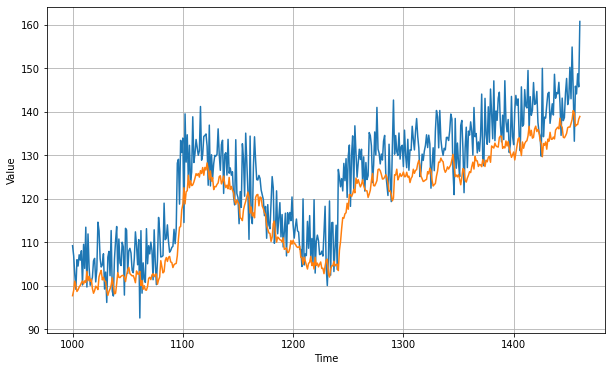

In [21]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [22]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.648016

## 학습률 튜닝

In [23]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], 
                          activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, 
                    callbacks=[lr_schedule], verbose=0)

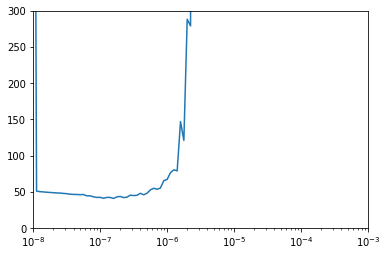

In [25]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])
plt.show()

학습률 1e-6에서 다시 훈련

In [26]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], 
                          activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

sgd = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss="mse",optimizer=sgd)
model.fit(dataset,epochs=100,verbose=1)

Epoch 1/100
1441/1441 [==============================] - 4s 3ms/step - loss: 107.7169
Epoch 2/100
1441/1441 [==============================] - 4s 3ms/step - loss: 67.1339
Epoch 3/100
1441/1441 [==============================] - 4s 3ms/step - loss: 63.9633
Epoch 4/100
1441/1441 [==============================] - 4s 3ms/step - loss: 66.9879
Epoch 5/100
1441/1441 [==============================] - 4s 3ms/step - loss: 82.2102
Epoch 6/100
1441/1441 [==============================] - 4s 3ms/step - loss: 65.1895
Epoch 7/100
1441/1441 [==============================] - 4s 3ms/step - loss: 66.4297
Epoch 8/100
1441/1441 [==============================] - 5s 3ms/step - loss: 57.1348
Epoch 9/100
1441/1441 [==============================] - 4s 3ms/step - loss: 60.7019
Epoch 10/100
1441/1441 [==============================] - 4s 3ms/step - loss: 61.1405
Epoch 11/100
1441/1441 [==============================] - 4s 3ms/step - loss: 63.3706
Epoch 12/100
1441/1441 [==============================] - 4s 3

In [ ]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(
        model.predict(series[time:time + window_size][np.newaxis]))
    
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

In [ ]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

## 케라스 튜너로 하이퍼파라미터 튜닝하기
   
케라스 튜너의 특징:   
테스트할 범위를 지정하여 하이퍼파라미터를 매개변수화 가능.   
지정한 특정 지표로 모델을 평가(objective 매개변수)   
=> 최상의 모델을 리포트

In [27]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 KB 15.9 MB/s eta 0:00:00


In [28]:
def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(
        units=hp.Int('units', min_value=10, max_value=30, step=2), 
        activation='relu', input_shape=[window_size]))
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    sgd = tf.keras.optimizers.SGD(
        learning_rate=1e-6,
        momentum=hp.Choice('momentum', values=[.9, .7, .5, .3]))
    model.compile(loss="mse", optimizer=sgd)
    return model

In [29]:
from keras_tuner.tuners import RandomSearch

In [30]:
# 케라스 튜너의 RandomSearch 객체를 만들어 모델읠 하이퍼파라미터 탐색을 위임

tuner = RandomSearch(build_model,
                     objective='loss', max_trials=150, 
                     executions_per_trial=3, directory='my_dir', 
                     project_name='hello', overwrite=True)
# objective='loss': 손실을 최소화하고자 하는 목적
# max_trials: 최대 탐색 횟수를 제한
# executions_per_trial: (랜덤한 변동을 줄이기 위해) 모델 훈련과 평가 횟수를 지정함

In [ ]:
tuner.search(dataset, epochs=100, verbose=0)

In [ ]:
tuner.results_summary()

In [ ]:
best_models = tuner.get_best_models(num_models=4) 

In [ ]:
model = best_models[0]

forecast = []
for time in range(len(series) - window_size):
    forecast.append(
        model.predict(series[time:time + window_size][np.newaxis]))
    
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

In [ ]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()